In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

true_b = .5
true_w = -3
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors and then we send them to the
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

x_val_tensor = torch.as_tensor(x_val).float().to(device)
y_val_tensor = torch.as_tensor(y_val).float().to(device)

train_data = TensorDataset(x_train_tensor, y_train_tensor)
val_data = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "a" and "b" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()

    return perform_val_step_fn

torch.manual_seed(42)

lr = 0.1

model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

train_step_fn = make_train_step_fn(model, loss_fn, optimizer)
val_step_fn = make_val_step_fn(model, loss_fn)

def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []

    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

print(model.state_dict())
print(losses[-1], val_losses[-1])

checkpoint = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epoch': n_epochs,
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

lr = 0.01

new_model = nn.Sequential(nn.Linear(1, 1)).to(device)
new_optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

checkpoint = torch.load('model_checkpoint.pth')

new_model.load_state_dict(checkpoint['model_state_dict'])
new_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

new_model.state_dict()

new_inputs = torch.tensor([[.20], [.34], [.57]])
model.eval() # always use EVAL for fully trained models!
model(new_inputs.to(device))


OrderedDict([('0.weight', tensor([[-3.0315]])), ('0.bias', tensor([0.5222]))])
0.008130191732198 0.005499828126630746


tensor([[-0.0841],
        [-0.5085],
        [-1.2058]], grad_fn=<AddmmBackward0>)

Figure(1000x400)


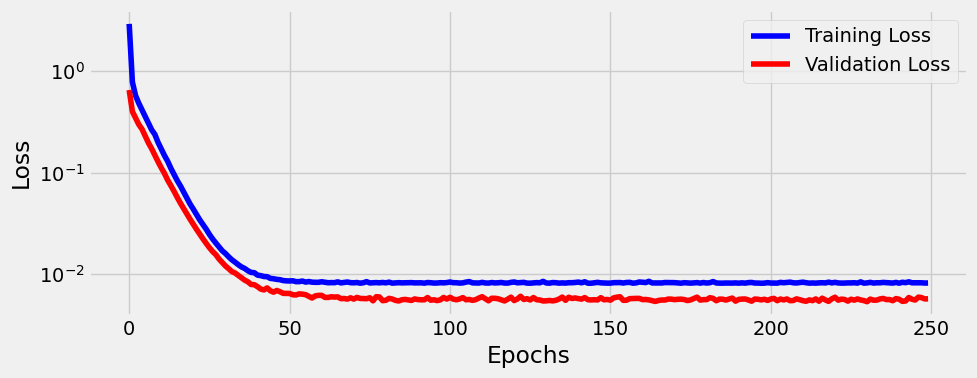

In [ ]:
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

    def _make_train_step(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step

    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4,
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

true_b = .5
true_w = -3
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

idx = np.arange(N)
np.random.shuffle(idx)

train_idx = idx[:int(N*.8)]
val_idx = idx[int(N*.8):]

x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

x_val_tensor = torch.as_tensor(x_val).float()
y_val_tensor = torch.as_tensor(y_val).float()

train_data = TensorDataset(x_train_tensor, y_train_tensor)
val_data = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(
    dataset = train_data,
    batch_size = 16,
    shuffle=True
)
val_loader = DataLoader(dataset = val_data, batch_size=16)

lr = 0.1
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1,1))
optimizer = optim.SGD(model.parameters(),lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

sbs = StepByStep(model,loss_fn,optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('classy')

sbs.train(n_epochs=200)
'''
print(model.state_dict())
print(sbs.total_epochs)
print(sbs.plot_losses())

new_data = np.array([.5,.3,.7]).reshape(-1,1)
prediction = sbs.predict(new_data)
print(prediction)
'''
sbs.save_checkpoint('model_checkpoint.pth')

new_sbs = StepByStep(model,loss_fn,optimizer)
new_sbs.load_checkpoint('model_checkpoint.pth')
new_sbs.set_loaders(train_loader,val_loader)
new_sbs.train(n_epochs=50)
print(new_sbs.plot_losses())

epochs: 10 losses: 0.44051808714866636
epochs: 20 losses: 0.3854432821273804
epochs: 30 losses: 0.3705441623926163
epochs: 40 losses: 0.3649975091218948
epochs: 50 losses: 0.3623473793268204
epochs: 60 losses: 0.36081927120685575
epochs: 70 losses: 0.3603967994451523
epochs: 80 losses: 0.35987205505371095
epochs: 90 losses: 0.3598998934030533
epochs: 100 losses: 0.3596454530954361
[[ 0.20345592]
 [ 2.9444451 ]
 [ 3.6933177 ]
 [-1.2334073 ]]


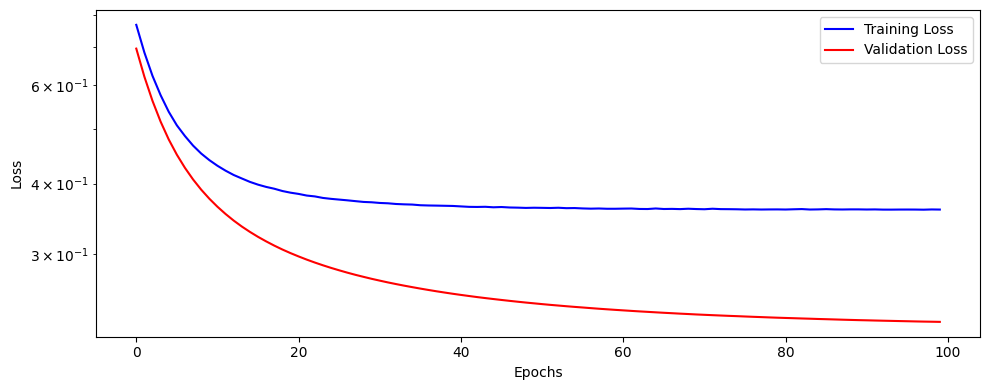

In [ ]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve,auc

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

    def _make_train_step(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step

    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4,
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            if self.total_epochs % 10==0:
                print('epochs:',self.total_epochs,'losses:',loss)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

X,y = make_moons(n_samples=100,noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=.2,random_state=13)
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

torch.manual_seed(13)

x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1,1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1,1)).float()

train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
val_dataset = TensorDataset(x_val_tensor,y_val_tensor)

train_loader = DataLoader(dataset=train_dataset,batch_size=16,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=16)
'''
b = -1
w1,w2 = 2,3
N=5

np.random.seed(42)
x1 = x2 = np.random.rand(N,1)
epsilon = (.1*np.random.randn(N,1))
y = b+(w1*x1) + (w2*x2)+epsilon

results = [1 if num >=0 else 0 for num in y]

print("y:")
print(y)
print("labels:")
print(results)
'''

lr=0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear',nn.Linear(2,1))

optimizer = optim.SGD(model.parameters(),lr=lr)

loss_fn = nn.BCEWithLogitsLoss()

n_epochs = 100

sbs = StepByStep(model,loss_fn,optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.train(n_epochs)

sbs.plot_losses()

predictions = sbs.predict(x_train_tensor[:4])
print(predictions)


In [ ]:
import numpy
import scipy.special

class neuralNetwork:

    def __init__(self,inputnodes,hiddennodes,outputnodes,learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))


        # learning rate
        self.lr = learningrate

        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)

    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

        pass

    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

input_nodes = 3
hidden_nodes = 3
output_nodes = 3

# learning rate is 0.3
learning_rate = 0.3

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)
a=n.query([1.0, 0.5, -1.5])
b=n.train([1.0,0.5,-1.5],[0.5,0.7,0.2])

print(a)

[[0.65517924]
 [0.60532976]
 [0.51868662]]


Files already downloaded and verified


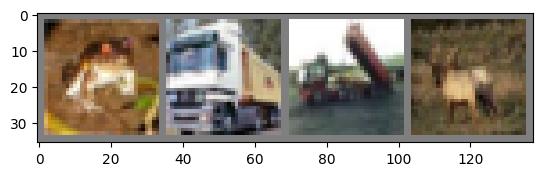

 frog truck truck  deer
Files already downloaded and verified


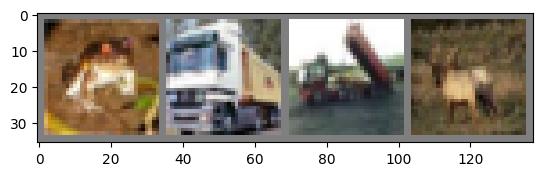

GroundTruth:   frog truck truck  deer
Predicted:  plane plane  frog plane


In [ ]:
import os
import sys
cwd = os.getcwd()
#add CIFAR10 data in the environment
sys.path.append(cwd + '/../cifar10')

#Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import utils
from torchvision import transforms
#CIFAR10 is a custom Dataloader that loads a subset ofthe data from a local folder
import keras
#from Cifar10Dataloader import CIFAR10

batch_size=4

def load_data():

    #convert the images to tensor and normalized them
    transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    return trainloader


def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(load_data())
images, labels = next(dataiter)

# show images
show_image(utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 1. DEFINE MODEL HERE
model = nn.Sequential(nn.Linear(3072, 128),
                          nn.ReLU(),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Linear(64, 10)
                          )

def train():

    training_data = load_data()

    # 2. LOSS AND OPTIMIZER
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    running_loss = 0.0

    for epoch in range(1):
        for i, data in enumerate(training_data, 0):

            inputs, labels = data
            #reshape images so they can be fed to a nn.Linear()
            inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()

            ##3. RUN BACKPROP
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 500 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Training finished')


#train()

def evaluate():
    dataiter = iter(load_data())
    images, labels = next(dataiter)

    # print images
    show_image(utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    images = images.view(images.size(0), -1)
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

evaluate()


Files already downloaded and verified
[1,  2000] loss: 2.184
[1,  4000] loss: 1.868
[1,  6000] loss: 1.700
[1,  8000] loss: 1.565
[1, 10000] loss: 1.533
[1, 12000] loss: 1.474
[2,  2000] loss: 1.776
[2,  4000] loss: 1.382
[2,  6000] loss: 1.320
[2,  8000] loss: 1.278
[2, 10000] loss: 1.291
[2, 12000] loss: 1.247
[3,  2000] loss: 1.535
[3,  4000] loss: 1.203
[3,  6000] loss: 1.160
[3,  8000] loss: 1.141
[3, 10000] loss: 1.157
[3, 12000] loss: 1.126
Finished Training
Files already downloaded and verified


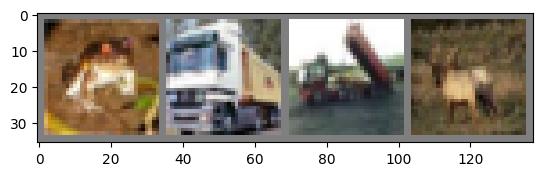

GroundTruth:   frog truck truck  deer
Predicted:   deer truck truck  deer


In [ ]:
import os
import sys
cwd = os.getcwd()
#add CIFAR10 data in the environment
sys.path.append(cwd + '/../cifar10')

#Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import utils
from torchvision import transforms
#CIFAR10 is a custom Dataloader that loads a subset ofthe data from a local folder
import keras
#from Cifar10Dataloader import CIFAR10

batch_size=4

def load_data():

    #convert the images to tensor and normalized them
    transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    return trainloader


def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train(model, training_data):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
    running_loss = 0.0
    for epoch in range(3):  # loop over the dataset multiple times

        for i, data in enumerate(training_data, 0):
            # get the inputs; cifar10 is a list of [inputs, labels]
            inputs,labels=data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            # print statistics
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training')



def evaluate(model):
    dataiter = iter(load_data())
    images, labels = next(dataiter)

    # print images
    show_image(utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))



def main():

    training_data = load_data()

    model = CNN()

    train(model, training_data)

    evaluate(model)

main()


STEP:  0
loss: 0.531062792553599
loss: 0.5192183692537967
loss: 0.5023206427207827
loss: 0.5005365391319079
loss: 0.49863185413232575
loss: 0.4938435005857664
loss: 0.4823892934450121
loss: 0.4211484445264467
loss: 0.18822204835805334
loss: 1.1588700510942787
loss: 0.06310744792099106
loss: 0.05433481757514551
loss: 0.05109528098553873
loss: 0.049337529376980625
loss: 0.047792402496385
loss: 0.04390511447772585
loss: 0.036673516007480464
loss: 0.022379711129737873
loss: 0.012698684200850283
loss: 0.008356162386038538
test loss: 0.0073472128087007545


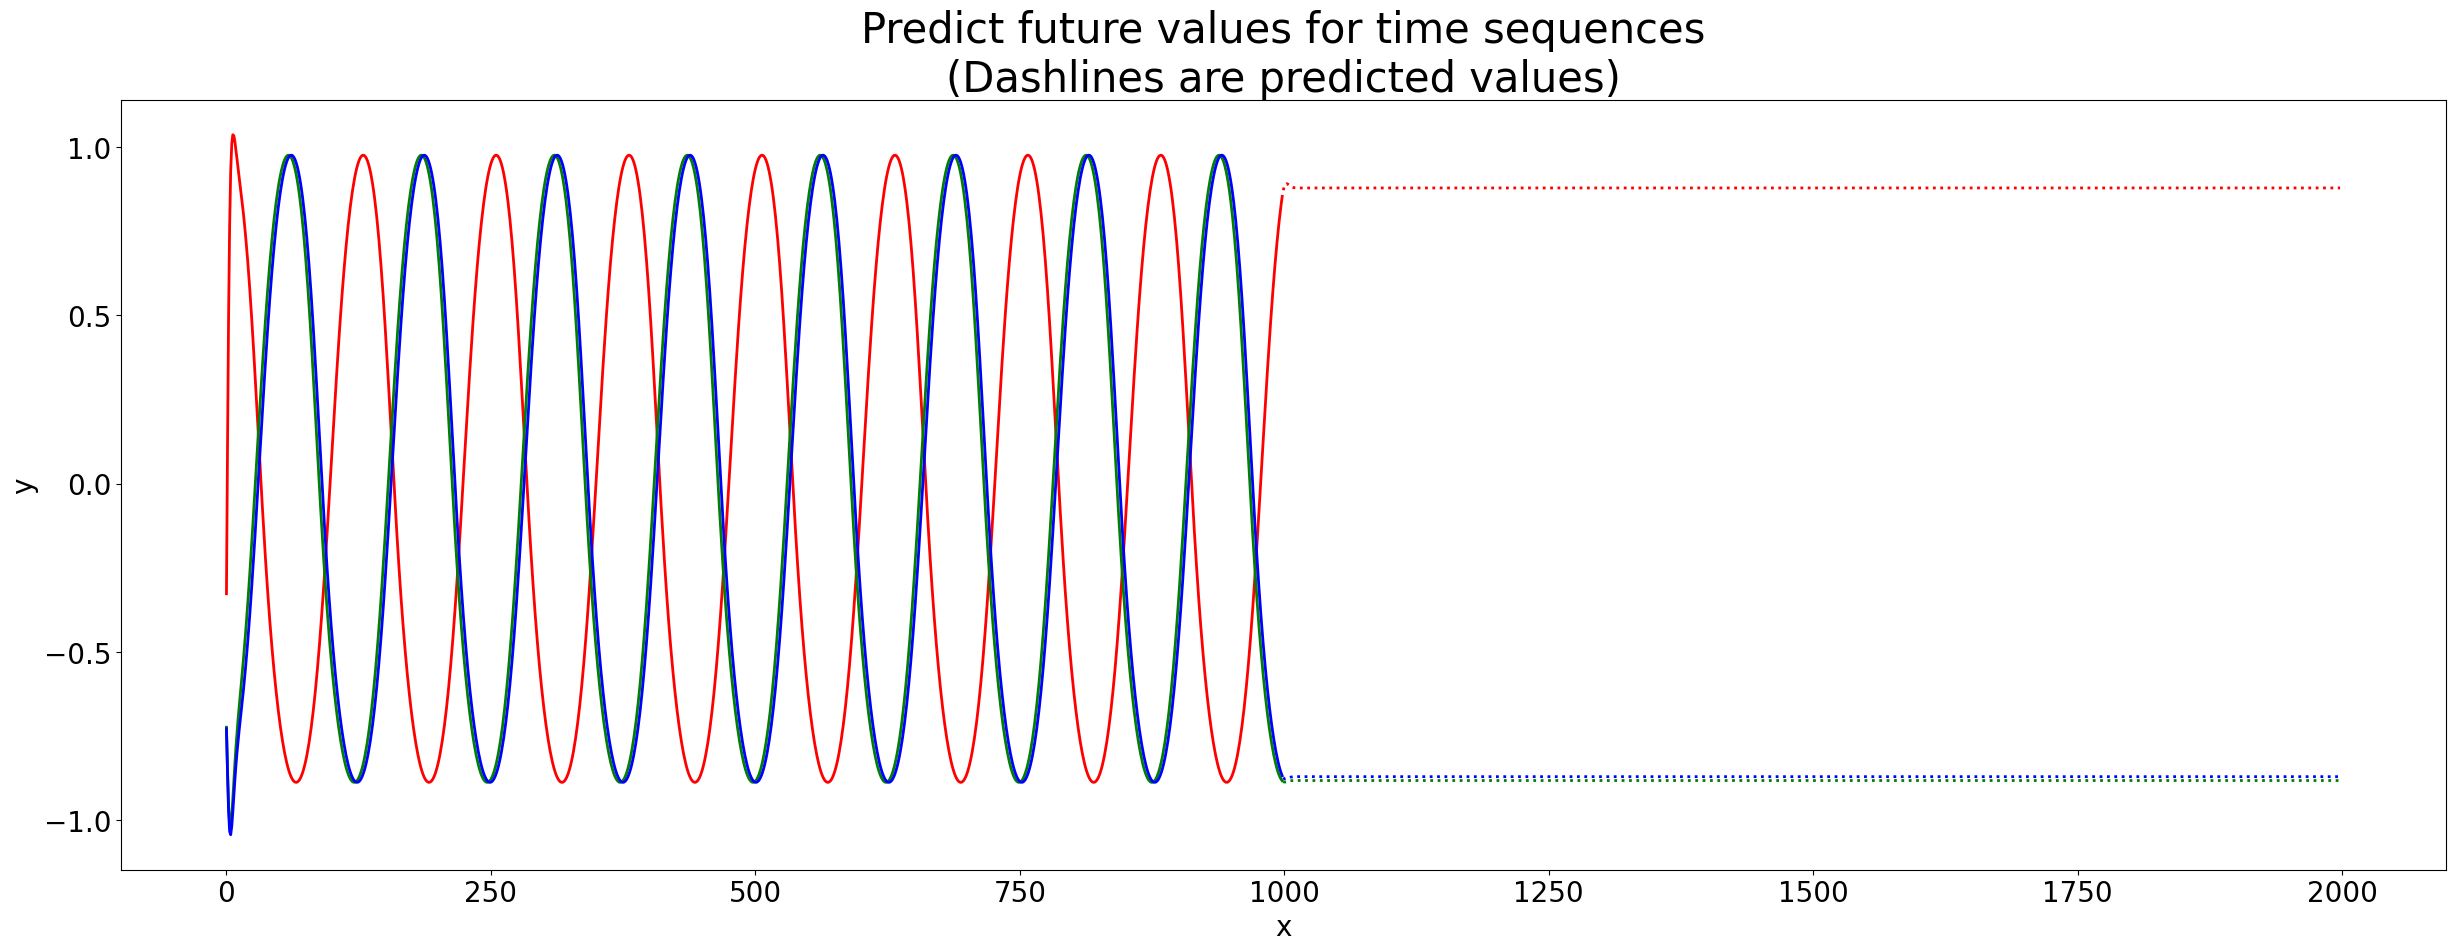

In [ ]:
import random
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch.optim as optim

#set seed to be able to replicate the resutls
seed = 172
random.seed(seed)
torch.manual_seed(seed)

def generate_sin_wave_data():
    T = 20
    L = 1000
    N = 200

    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    #data = np.sin(x / 1.0 / T).astype('float64')
    data = np.cos(x / 1.0 / T).astype('float64')
    return data

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()

        self.rnn1 = nn.LSTMCell(1, 51)
        self.rnn2 = nn.LSTMCell(51, 51)
        self.rnn3 = nn.LSTMCell(51, 51)

        self.linear = nn.Linear(51, 1)

    def forward(self, input, future=0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t3 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t3 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

            h_t, c_t = self.rnn1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.rnn3(h_t2, (h_t3, c_t3))

            output = self.linear(h_t3)
            outputs += [output]

        # if we should predict the future
        for i in range(future):

            h_t, c_t = self.rnn1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.rnn3(h_t2, (h_t3, c_t3))

            output = self.linear(h_t3)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


def train():
    # load data and make training set
    data = generate_sin_wave_data()
    input = torch.from_numpy(data[3:, :-1])
    target = torch.from_numpy(data[3:, 1:])
    test_input = torch.from_numpy(data[:3, :-1])
    test_target = torch.from_numpy(data[:3, 1:])

    seq = Sequence()

    seq.double()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

    # begin to train
    for i in range(1):
        print('STEP: ', i)

        def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss

        optimizer.step(closure)

        # begin to predict, no need to track gradient here
        with torch.no_grad():
            future = 1000
            pred = seq(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print('test loss:', loss.item())
            y = pred.detach().numpy()

        # draw the result
        plt.figure(figsize=(30, 10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth=2.0)
            plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth=2.0)

        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        plt.show()


if __name__ == '__main__':
    generate_sin_wave_data()
    train()

performance =  0.9657
[0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


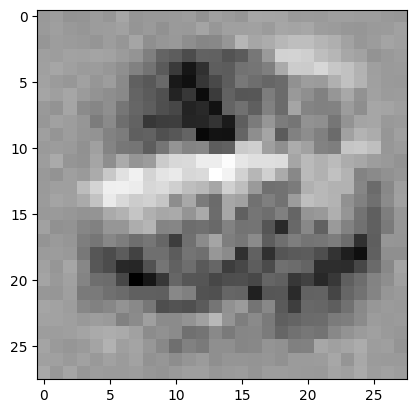

In [ ]:
import numpy
# scipy.special for the sigmoid function expit(), and its inverse logit()
import scipy.special
# library for plotting arrays
import matplotlib.pyplot
# ensure the plots are inside this notebook, not an external window
%matplotlib inline

class neuralNetwork:


    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate

        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)

        pass


    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

        pass


    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        return final_outputs


    # backquery the neural network
    # we'll use the same termnimology to each item,
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T

        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01

        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)

        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01

        return inputs

input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)
filepath1='/content/sample_data/mnist_train_100.csv'
filepathbig1='/content/sample_data/mnist_train_small.csv'
training_data_file = open(filepathbig1,'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

epochs = 5
#epoch=5 값원래 기본 근데 런타임길어서 1롤줄임
for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass

filepath2 = '/content/sample_data/mnist_test_10.csv'
filepathbig2 = '/content/sample_data/mnist_test.csv'
test_data_file = open(filepathbig2, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale and shift the inputs
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass

    pass

scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

label = 2
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')




In [ ]:
filepath1='/content/sample_data/mnist_train_small.csv'
training_data_file = open(filepath1, 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

print(training_data_file)

<_io.TextIOWrapper name='/content/sample_data/mnist_train_small.csv' mode='r' encoding='UTF-8'>


In [ ]:
import ssl
import torch
import torch.nn as nn
from torchvision import transforms, datasets

# ssl._create_default_https_context = ssl._create_unverified_context


BATCH_SIZE = 32
train_dataset = datasets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

print(train_loader.dataset)

for (X_train, Y_train) in train_loader:
    print(f"X_train: {X_train.size()} type: {X_train.type()}")
    print(f"Y_train: {Y_train.size()} type: {Y_train.type()}")
    break


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=3,
            padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            padding=1)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x


DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using PyTorch version: {torch.__version__}, Device: {DEVICE}")

model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                f"train Epoch: {Epoch} [{batch_idx * len(image)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tTrain Loss: {loss.item()}")


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

EPOCHS = 50
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH: {Epoch}]\tTest Loss: {test_loss:.4f}\tTest Accuracy: {test_accuracy} % \n")

100%|██████████| 170498071/170498071 [00:05<00:00, 29717551.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()
X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
Using PyTorch version: 2.0.1+cu118, Device: cuda
train Epoch: 1 [0/50000(0%)]	Train Loss: 2.34501051902771
train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.9789830446243286
train Epoch: 1 [12800/50000(26%)]	Train Loss: 2.0275931358337402
train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.804667592048645
train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.7086081504821777
train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.6762800216674805
train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.44551420211792
train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.2683415412902832

[EPOCH: 1]	Test Loss: 0.0464	Test Accuracy: 45.35 % 

train Epoch: 2 [0/50000(0%)]	Train Loss: 1.69754564

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
